In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch, add_image
import matplotlib.patches as mpatches
import shapely.geometry as geom
from PIL import Image
from urllib.request import urlopen

In [2]:
STATSBOMB = os.path.join('..', 'data', 'statsbomb')
df_event = pd.read_parquet(os.path.join(STATSBOMB, 'event.parquet'))

In [3]:
n_matches = df_event.match_id.nunique()
print(n_matches)

855


Filter for open-play shots

In [4]:
df_event = df_event[(df_event.type_name=='Shot')&(df_event.event_type_name=='Open Play')].copy()
print('Number of shots:', len(df_event))

Number of shots: 20264


Load StatsBomb Logo

In [5]:
logo = np.array(Image.open('SB_Regular.png'))
logo_alt = np.array(Image.open('SB_Regular_Alt.png'))

Goal probabilities heatmap

In [6]:
df_event['goal'] = (df_event.outcome_name == 'Goal')

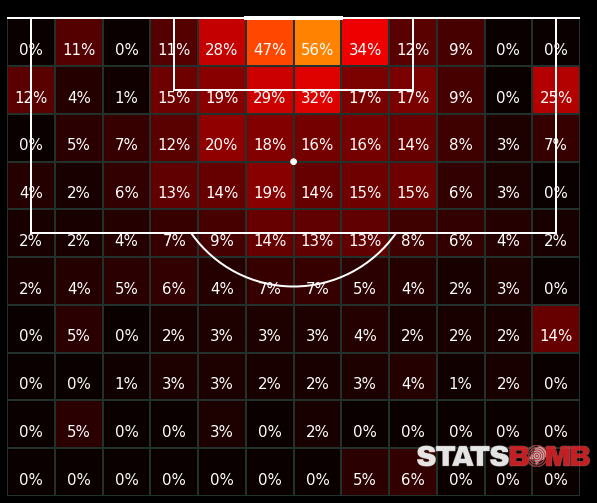

In [7]:
plt.style.use('dark_background')
pitch = Pitch(figsize=(16, 9), tight_layout=False, view='half', orientation='vertical', line_zorder=2,
              pad_left=-16, pad_right=-16, pad_bottom=-20, pad_top=1)
fig, ax = pitch.draw()
bs = pitch.bin_statistic(df_event.x, df_event.y, df_event.goal, statistic='mean', bins=(30, 20))
bs['statistic'] = np.round(np.nan_to_num(bs['statistic']) * 100., 0).astype(np.int32)
pcm = pitch.heatmap(bs, ax=ax, cmap='hot', edgecolors='#22312b')
bs['statistic'] = (pd.DataFrame(bs['statistic']).round(0).astype(np.int32).applymap(lambda x: '{:d}%'.format(x)).values)
annotation = pitch.label_heatmap(bs, color='white', fontsize=15, ax=ax, ha='center', va='top', zorder=3)
ax_image = add_image(logo_alt, fig, left=0.62, bottom=0.17, width=0.15, alpha=0.9, interpolation='hanning')
fig.savefig(os.path.join('figures', 'goal_probabilities_heatmap.png'), bbox_inches = 'tight', pad_inches = 0)

Create Shapely polygons for red zone, 27.2 yard radius from centre, and the rest of the pitch

In [8]:
# pitch polygon
pitch = Pitch()
pitch_poly = geom.Polygon(np.array([[pitch.right, pitch.top],
                                    [pitch.right, pitch.bottom],
                                    [pitch.left, pitch.bottom],
                                    [pitch.left, pitch.top]]))
# red zone
red_zone_point = pitch.right_penalty - pitch.circle_size
half_red_zone_width = pitch.penalty_area_width/11 * 4
red_zone = np.array([[pitch.right, pitch.center_width + half_red_zone_width],
                     [pitch.right, pitch.center_width - half_red_zone_width],
                     [red_zone_point, pitch.center_width]])
poly_redzone = geom.Polygon(red_zone)
# orange zone
orange_zone = np.array([[pitch.right, pitch.center_width + half_red_zone_width],
                        [pitch.right, pitch.center_width - half_red_zone_width],
                        [red_zone_point, pitch.center_width - half_red_zone_width],
                        [red_zone_point, pitch.center_width + half_red_zone_width]])
poly_orangezone = geom.Polygon(orange_zone)
# 27.2 yards
arc_radius = ((pitch.penalty_area_width / 2) ** 2 + (pitch.penalty_area_length) ** 2) ** 0.5
diameter_27y_approx = arc_radius * 2 
print('Appoximate yards of arc', (arc_radius / pitch.right) * 105 * 1.09361)
print('Appoximate metres of arc', (arc_radius / pitch.right) * 105)
circle = geom.Point(pitch.right, pitch.center_width).buffer(diameter_27y_approx / 2.)
poly_27y_approx = pitch_poly.intersection(circle)
poly_27y_approx_minus_orangezone = poly_27y_approx.difference(poly_orangezone)
# rest of the pitch
poly_rest_of_pitch = pitch_poly.difference(poly_27y_approx)

Appoximate yards of arc 27.200457340049677
Appoximate metres of arc 24.872173206215816


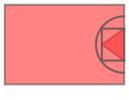

In [9]:
geom.MultiPolygon([poly_27y_approx_minus_orangezone, poly_redzone, poly_rest_of_pitch, poly_orangezone])

Get coordinates of polygons for plotting

In [10]:
redx, redy = poly_redzone.exterior.xy
red = np.concatenate([np.expand_dims(redx, 1), np.expand_dims(redy, 1)], axis=1)
orangex, orangey = poly_orangezone.exterior.xy
orange = np.concatenate([np.expand_dims(orangex, 1), np.expand_dims(orangey, 1)], axis=1)
yellowx, yellowy = poly_27y_approx_minus_orangezone.exterior.xy
yellow = np.concatenate([np.expand_dims(yellowx, 1), np.expand_dims(yellowy, 1)], axis=1)
otherx, othery = poly_rest_of_pitch.exterior.xy
other = np.concatenate([np.expand_dims(otherx, 1), np.expand_dims(othery, 1)], axis=1)

Add to event dataset whether shots is within the zones

In [11]:
bool_red_zone = []
bool_orange_zone = []
bool_yellow_zone = []
bool_rest_of_pitch = []
shot_points = geom.MultiPoint(df_event[['x', 'y']].values)
for p in shot_points:
    bool_red_zone.append(p.intersects(poly_redzone))
    bool_yellow_zone.append(p.intersects(poly_27y_approx_minus_orangezone))
    bool_orange_zone.append(p.intersects(poly_orangezone))
    bool_rest_of_pitch.append(p.intersects(poly_rest_of_pitch))
df_event['red_zone'] = bool_red_zone
df_event['orange_zone'] = bool_orange_zone
df_event['yellow_zone'] = bool_yellow_zone
df_event['other_zone'] = bool_rest_of_pitch
# If the point lies on the edge of the orange and yellow zone, asign to orange zone
df_event.loc[(df_event.orange_zone) & (df_event.yellow_zone), 'yellow_zone'] = False

Calculate percentages of goals in each zone

In [12]:
# red triangle
red_zone_prop = (df_event[df_event.outcome_name=='Goal'].red_zone.value_counts())/(df_event.outcome_name=='Goal').sum()
red_zone_prop = int(round(red_zone_prop[red_zone_prop.index].values[0] * 100, 0))
# orange rectangle
orange_zone_prop = (df_event[df_event.outcome_name=='Goal'].orange_zone.value_counts())/(df_event.outcome_name=='Goal').sum()
orange_zone_prop = int(round(orange_zone_prop[orange_zone_prop.index].values[0] * 100, 0))
# arc minus orange rectangle
yellow_zone_prop = (df_event[df_event.outcome_name=='Goal'].yellow_zone.value_counts())/(df_event.outcome_name=='Goal').sum()
yellow_zone_prop = int(round(yellow_zone_prop[yellow_zone_prop.index].values[0] * 100, 0))
# greater than arc
other_zone_prop = (df_event[df_event.outcome_name=='Goal'].other_zone.value_counts())/(df_event.outcome_name=='Goal').sum()
other_zone_prop = int(round(other_zone_prop[other_zone_prop.index].values[0] * 100, 0))
# check
print('Check around 100%:', other_zone_prop + yellow_zone_prop + orange_zone_prop)

Check around 100%: 100


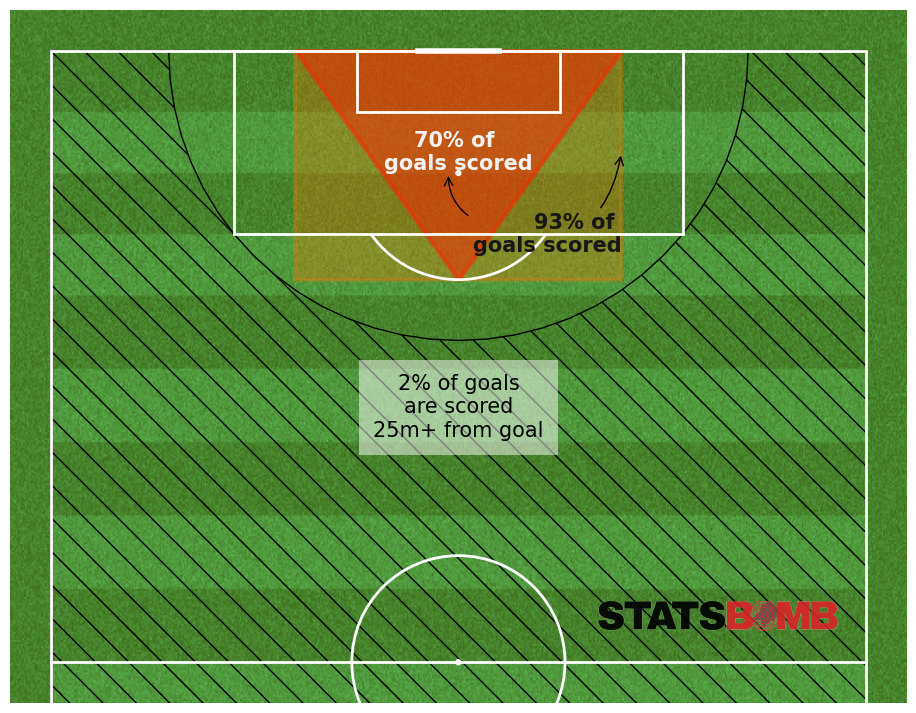

In [13]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
pitch = Pitch(orientation='vertical', view='half', figsize=(16, 9), 
             line_zorder=2, line_color='white', pitch_color='grass', stripe=True, tight_layout=False)
fig, ax = pitch.draw()
red_zone = pitch.polygon([red], ax=ax, edgecolor='#ff0000',alpha=0.5, lw=3, facecolor='#ff0000')
orange_zone = pitch.polygon([orange], ax=ax, edgecolor='#ff7400', lw=3, alpha=0.3, facecolor='#ff7400')
other_zone = pitch.polygon([other], ax=ax, edgecolor='black', alpha=1, facecolor='None', hatch='\\')
pitch.annotate(f'{red_zone_prop}% of \ngoals scored', (110, 40), va='center', ha='center',
               fontsize=15, fontweight='bold', color='#F2F2F2', ax=ax)
pitch.annotate(f'{orange_zone_prop}% of \ngoals scored', xy=(110, 56), xytext=(102, 56),
               arrowprops=dict(arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=80"),
               fontweight='bold', color='#171717',
               va='center', ha='right', fontsize=15, ax=ax)
pitch.annotate(f'{orange_zone_prop}% of \ngoals scored', xy=(108, 39), xytext=(102, 56),
               arrowprops=dict(arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=90"),
               fontweight='bold', color='None',
               va='center', ha='right', fontsize=15, ax=ax)
pitch.annotate(f'{other_zone_prop}% of goals\nare scored\n25m+ from goal', (85, 40), va='center', ha='center',
               fontsize=15, bbox={'facecolor':'white', 'alpha': 0.5, 'pad':10, 'edgecolor': 'None'}, ax=ax)
ax_image = add_image(logo, fig, left=0.6, bottom=0.19, width=0.15, alpha=0.9, interpolation='hanning')
fig.savefig(os.path.join('figures', 'red_zone_heatmap.png'), bbox_inches = 'tight', pad_inches = 0)